In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

kc_house_data = pd.read_csv('gdrive/My Drive/uwml/kc_house_data.csv', dtype=dtype_dict)
wk3_kc_house_test_data = pd.read_csv('gdrive/My Drive/uwml/kc_house_test_data.csv', dtype=dtype_dict)
wk3_kc_house_train_data = pd.read_csv('gdrive/My Drive/uwml/kc_house_train_data.csv', dtype=dtype_dict)

In [4]:
kc_house_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340.0,5650.0
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690.0,7639.0
2,5631500400,20150225T000000,180000.0,2.0,1.00,770.0,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720.0,8062.0
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960.0,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360.0,5000.0
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680.0,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800.0,7503.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,0263000018,20140521T000000,360000.0,3.0,2.50,1530.0,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530.0,1509.0
21609,6600060120,20150223T000000,400000.0,4.0,2.50,2310.0,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830.0,7200.0
21610,1523300141,20140623T000000,402101.0,2.0,0.75,1020.0,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020.0,2007.0
21611,0291310100,20150116T000000,400000.0,3.0,2.50,1600.0,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410.0,1287.0


In [5]:
def get_numpy_data(df, features, output):
  df['constant'] = 1
  x_list = ['constant'] + features
  x = df[x_list]
  x = x.to_numpy()
  y = df[output]
  y = y.to_numpy()
  return(x, y)

x_test, y_test = get_numpy_data(kc_house_data, ['sqft_living'], 'price')

x_test

array([[1.00e+00, 1.18e+03],
       [1.00e+00, 2.57e+03],
       [1.00e+00, 7.70e+02],
       ...,
       [1.00e+00, 1.02e+03],
       [1.00e+00, 1.60e+03],
       [1.00e+00, 1.02e+03]])

In [6]:
def predict_outcome(feature_matrix, weights):
  predictions = np.dot(feature_matrix, weights)
  return(predictions)

dummy_weights = np.array([-47000., 1.])  #np.random.rand(2)

yhat = predict_outcome(x_test, dummy_weights)
yhat

array([-45820., -44430., -46230., ..., -45980., -45400., -45980.])

In [7]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
  if feature_is_constant:
    derivative = 2*np.dot(errors, feature)
    #derivative = 2*sum(errors*feature)
  else:
    derivative = 2*np.dot(errors, feature) + 2*l2_penalty*weight
    #derivative = 2*sum(errors*feature) + 2*l2_penalty*weight
  return derivative

In [8]:
# Test
example_features, example_output = get_numpy_data(kc_house_data, ['sqft_living'], 'price')
my_weights = np.array([1., 10.])
test_predictions = predict_outcome(example_features, my_weights)
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print(feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False))
print(np.sum(errors*example_features[:,1])*2+20)
print("\n")

# next two lines should print the same values
print(feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True))
print(np.sum(errors)*2)

-56554166815950.0
-56554166815950.0


-22446749330.0
-22446749330.0


In [9]:
# Gradient descent
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations):
  
  weights = np.array(initial_weights) 
  
  #while not reached maximum number of iterations:
  iter = 0
  #for iter in range(max_iterations):
  while iter <= max_iterations:
    #print('Iteration', iter)
    
    # compute the predictions using your predict_output() function
    yhat = predict_outcome(feature_matrix, weights)
    # compute the errors as predictions - output
    errors = yhat - output

    for i in range(len(weights)): # loop over each weight
      # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
      feature = feature_matrix[:,i]
      # compute the derivative for weight[i].
      if i == 0:
        feature_is_constant = True
      else:
        feature_is_constant = False

      feature_deriv = feature_derivative_ridge(errors, feature, weights[i], l2_penalty, feature_is_constant)

      # subtract the step size times the derivative from the current weight
      update = -step_size*feature_deriv
      weights[i] = weights[i] + update
    
    #print('2nd i:', weights)
    
    iter+=1

  return weights

In [10]:
# Data
simple_features = ['sqft_living']
my_output = 'price'
simple_feature_matrix, output = get_numpy_data(wk3_kc_house_train_data, simple_features, my_output)
simple_test_feature_matrix, test_output = get_numpy_data(wk3_kc_house_test_data, simple_features, my_output)

simple_feature_matrix

array([[1.00e+00, 1.18e+03],
       [1.00e+00, 2.57e+03],
       [1.00e+00, 7.70e+02],
       ...,
       [1.00e+00, 1.53e+03],
       [1.00e+00, 1.60e+03],
       [1.00e+00, 1.02e+03]])

In [11]:
output

array([221900., 538000., 180000., ..., 360000., 400000., 325000.])

In [12]:
# Step 12 / Q.1
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights=np.array([0.,0.]), step_size=1e-12, l2_penalty=0, max_iterations=1000)
simple_weights_0_penalty

array([-1.63382329e-01,  2.63024369e+02])

In [13]:
# Step 13 / Q.2
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights=[0.,0.], step_size=1e-12, l2_penalty=1e11, max_iterations=1000)
simple_weights_high_penalty

array([  9.77704731, 124.57217382])

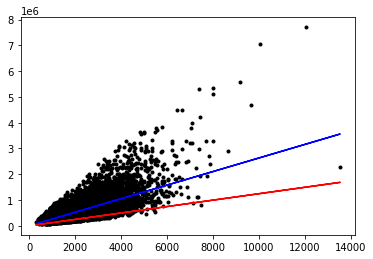

In [14]:
# Plot models / Q.3
plt.plot(
  simple_feature_matrix[:,1], output,'k.',
  simple_feature_matrix[:,1], predict_outcome(simple_feature_matrix, simple_weights_0_penalty),'b-',
  simple_feature_matrix[:,1], predict_outcome(simple_feature_matrix, simple_weights_high_penalty),'r-'
  )

In [15]:
# Step 18 / Q.4
rss_zero_weights = sum((predict_outcome(simple_test_feature_matrix, [0.,0.]) - test_output)**2)/1e12
rss_zero_penalty = sum((predict_outcome(simple_test_feature_matrix, simple_weights_0_penalty) - test_output)**2)/1e12 
rss_high_penalty = sum((predict_outcome(simple_test_feature_matrix, simple_weights_high_penalty) - test_output)**2)/1e12 

print('rss_zero_weights : ', rss_zero_weights)
print('rss_zero_penalty : ', rss_zero_penalty)
print('rss_high_penalty : ', rss_high_penalty)

rss_zero_weights :  1784.273286136298
rss_zero_penalty :  275.7236321432432
rss_high_penalty :  694.6420892802284


In [16]:
# Two features
model_features = ['sqft_living', 'sqft_living15']
my_output = 'price'
feature_matrix, output = get_numpy_data(wk3_kc_house_train_data, model_features, my_output)
test_feature_matrix, test_output = get_numpy_data(wk3_kc_house_test_data, model_features, my_output)

In [17]:
# Step 22 / Q.5&6
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights=[0.,0.,0.], step_size=1e-12, l2_penalty=0, max_iterations=1000)
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights=[0.,0.,0.], step_size=1e-12, l2_penalty=1e11, max_iterations=1000)
print(multiple_weights_0_penalty)
print(multiple_weights_high_penalty)

[ -0.35780714 243.05572642  22.41312485]
[ 6.74968592 91.48927275 78.43658676]


In [18]:
# Step 24 / Q.7
rss_mult_zero_weights = sum((predict_outcome(test_feature_matrix, [0.,0.,0.]) - test_output)**2)/1e12
rss_mult_zero_penalty = sum((predict_outcome(test_feature_matrix, multiple_weights_0_penalty) - test_output)**2)/1e12 
rss_mult_high_penalty = sum((predict_outcome(test_feature_matrix, multiple_weights_high_penalty) - test_output)**2)/1e12 

print('rss_mult_zero_weights : ', rss_mult_zero_weights)
print('rss_mult_zero_penalty : ', rss_mult_zero_penalty)
print('rss_mult_high_penalty : ', rss_mult_high_penalty)

rss_mult_zero_weights :  1784.273286136298
rss_mult_zero_penalty :  274.06769197851537
rss_mult_high_penalty :  500.40479677931614


In [19]:
# Step 25 & 26 / Q.8
print('multiple_weights_0_penalty - house 1', predict_outcome(test_feature_matrix, multiple_weights_0_penalty)[0])
print('multiple_weights_high_penalty - house 1', predict_outcome(test_feature_matrix, multiple_weights_high_penalty)[0])
print('actual - house 1', test_output[0])

print('multiple_weights_0_penalty - house 1 error', predict_outcome(test_feature_matrix, multiple_weights_0_penalty)[0] - test_output[0])
print('multiple_weights_high_penalty - house 1 error', predict_outcome(test_feature_matrix, multiple_weights_high_penalty)[0] - test_output[0])

multiple_weights_0_penalty - house 1 387464.69321329583
multiple_weights_high_penalty - house 1 270453.5341468127
actual - house 1 310000.0
multiple_weights_0_penalty - house 1 error 77464.69321329583
multiple_weights_high_penalty - house 1 error -39546.465853187314
